<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


For Model: DCT
Mean absolute error: 0.5506848651108447
Root mean squared error: 0.8827103304474709




For Model: KNN
Mean absolute error: 1.040196525256187
Root mean squared error: 1.4873615181472466


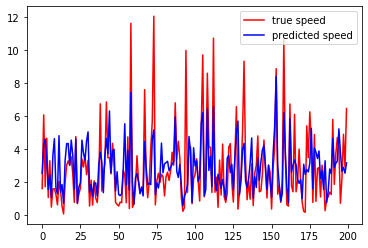

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree            import DecisionTreeRegressor  
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import mean_absolute_error
from math     import sqrt

import matplotlib.pyplot as plt
import pandas as pd

import requests
import io
import re

#data from each site was collected from 1/1/2018 00:00 to 12/31/18 23:50 at 10-minute intervals
DIR = "https://raw.githubusercontent.com/vanessavidas/CS-458-Project-Task-2/master/"

URLS = {'WB': DIR + "Snake-Range-WB.csv",       #Snake Range West Sagebrush
        'WA': DIR + "Snake-Range-WA.csv",       #Snake Range West Subalpine
        'WM': DIR + "Snake-Range-WM.csv",       #Snake Range West Montane
        'WP': DIR + "Snake-Range-WP.csv",       #Snake Range West Pinyon-Juniper
        'EA': DIR + "Snake-Range-EA.csv",       #Snake Range East Subalpine
        'EB': DIR + "Snake-Range-EB.csv",       #Snake Range East Sagebrush
        'ED': DIR + "Snake-Range-ED.csv"}       #Snake Range East Salt Desert Shrub

def main():
    """
    For each site in the dictionary of URLS, create new Pandas Dataframes using
    get_site_data() that can then be added on to the larger, all-encompassing
    dataset (X) and label series (y). Test the accuracy of these larger datasets
    using try_models()
    """
    X = pd.DataFrame(columns=['month', 'day', 'hour', 'minute', 'sitenumber'])
    y = pd.Series()

    for site_num, site in enumerate(URLS.keys()):
        (X_new, y_new) = get_site_data(URLS[site], site_num, X.columns)
        X = X.append(X_new, ignore_index=True)
        y = y.append(y_new, ignore_index=True)
    
    try_models(X, y)
    return

###############################################################################
def get_site_data(URL: str, site_num: int, cols: pd.Series) -> tuple:
    """
    Load a dataset from the given URL using Pandas read_csv(), and split it into
    X and y components. Additionally, impute missing y values with the mean.
    Rather than leaving the dataset in the form of a time series and using an
    ARMA / ARMAX / ARIMA model, we go out on a limb to create features for each
    time component (day, hour, minute, etc.) in order to use non-time-series-specific
    regression models like KNN and Decision Trees.

    Returns:
        X_new (pd.DataFrame): the parsed dataset for the given site
        y_new (pd.Series)   : the labels for the given site

    TO DO:
    1. Impute missing values of y with a more sophisticated technique
    """
    L = requests.get(URL).content
    df = pd.read_csv(io.StringIO(L.decode('ASCII')), skiprows = 9, header=None)

    X_new = df[0].to_frame()
    y_new = df[1]
    
    y_new.fillna(y_new.mean(), inplace=True) 

    datetimes = []
    for i in X_new.index:
        dt_str_ = X_new.iloc[i][0]
        dt_list = re.split('-|T|:', dt_str_)[1:5]
        dt_list.append(site_num)
        datetimes.append(dt_list)
    X_new = pd.DataFrame(datetimes, columns=cols)
    return (X_new, y_new)

###############################################################################
def try_models(X: pd.DataFrame, y: pd.Series):
    """
    Split the datasets into training and verification components. Fit each given
    regressor mdoel to the training sets and use those regressors to predict
    the windspeeds for each entry in the verification dataset. Plot the first 
    200 results (works better with an interactive console / pop-out window).
    Print performance metrics for each regressor, including RMSE and MAE.
    """
    (X_train, X_verif, y_train, y_verif) = train_test_split(X, y) 

    for CLF_NAME in ['DCT', 'KNN']:
        if CLF_NAME == 'DCT':
            regr = DecisionTreeRegressor(max_depth=25).fit(X_train, y_train)
        else:
            regr = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)

        y_pred = regr.predict(X_verif)
        
        mae_ = mean_absolute_error(y_verif, y_pred)
        rmse = sqrt(mean_squared_error(y_verif, y_pred))
    
        print("\n\nFor Model: {}".format(CLF_NAME))
        print("Mean absolute error: {}".format(mae_))
        print("Root mean squared error: {}".format(rmse))


        plt.plot(range(len(y_verif[0:200] )), y_verif[0:200] , 'r-', label='true speed')
        plt.plot(range(len(y_pred[0:200] )), y_pred[0:200], 'b-', label='predicted speed')
        plt.legend()
        plt.show()
        pass 

###############################################################################
    
main()